# CS-564 Assignment 3: Neural Networks for MNIST Digit Classification

Roll Numbers: 2201CB09, 2201CB25, 2201EE82


# STEP 1: IMPORT REQUIRED LIBRARIES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


# STEP 2: DATA PREPROCESSING


2.1: Loading MNIST Dataset
--------------------------------------------------------------------------------
Fetching MNIST dataset from OpenML...
✓ Dataset loaded successfully!
  - Total samples: 70000
  - Features per sample: 784 (28x28 pixels flattened)
  - Number of classes: 10 (digits 0-9)

2.2: Splitting Dataset
--------------------------------------------------------------------------------
Splitting into train (54,000), validation (6,000), and test (10,000)...
✓ Data split completed!
  - Training set: 54000 samples
  - Validation set: 6000 samples
  - Test set: 10000 samples

2.3: Normalizing Pixel Values (Min-Max Scaling)
--------------------------------------------------------------------------------
Scaling pixel values from [0, 255] to [0, 1]...
✓ Normalization completed!
  - Original range: [0, 255]
  - Normalized range: [0.0, 1.0]

2.4: One-Hot Encoding Labels
--------------------------------------------------------------------------------
Converting integer labels to one

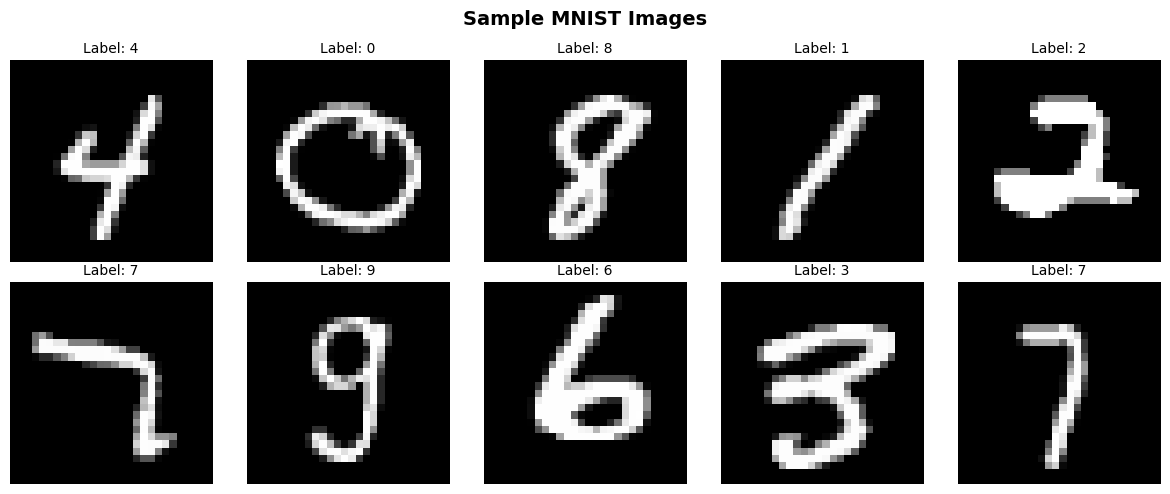

✓ Data preprocessing completed successfully!



In [ ]:
# 2.1: Load MNIST Dataset
print("\n2.1: Loading MNIST Dataset")
print("-"*80)
print("Fetching MNIST dataset from OpenML...")

mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data.values, mnist.target.values.astype(int)

print(f"✓ Dataset loaded successfully!")
print(f"  - Total samples: {X.shape[0]}")
print(f"  - Features per sample: {X.shape[1]} (28x28 pixels flattened)")
print(f"  - Number of classes: {len(np.unique(y))} (digits 0-9)")


# 2.2: Split into Train, Validation, and Test sets
print("\n2.2: Splitting Dataset")
print("-"*80)
print("Splitting into train (54,000), validation (6,000), and test (10,000)...")

# First split: separate test set (10,000 samples)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)

# Second split: separate validation set (10% of training = 6,000 samples)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

print(f"✓ Data split completed!")
print(f"  - Training set: {X_train.shape[0]} samples")
print(f"  - Validation set: {X_val.shape[0]} samples")
print(f"  - Test set: {X_test.shape[0]} samples")


# 2.3: Normalize pixel values using Min-Max scaling
print("\n2.3: Normalizing Pixel Values (Min-Max Scaling)")
print("-"*80)
print("Scaling pixel values from [0, 255] to [0, 1]...")

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print(f"✓ Normalization completed!")
print(f"  - Original range: [0, 255]")
print(f"  - Normalized range: [{X_train.min():.1f}, {X_train.max():.1f}]")


# 2.4: Convert labels to one-hot encoding
print("\n2.4: One-Hot Encoding Labels")
print("-"*80)
print("Converting integer labels to one-hot encoded vectors...")
print("Example: label 3 → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]")

def one_hot_encode(y, num_classes=10):
    """
    Convert integer labels to one-hot encoded vectors

    Args:
        y: Array of integer labels
        num_classes: Number of classes (10 for digits)

    Returns:
        One-hot encoded array of shape (n_samples, num_classes)
    """
    n_samples = y.shape[0]
    one_hot = np.zeros((n_samples, num_classes))
    one_hot[np.arange(n_samples), y] = 1
    return one_hot

# Encode training, validation, and test labels
y_train_encoded = one_hot_encode(y_train)
y_val_encoded = one_hot_encode(y_val)
y_test_encoded = one_hot_encode(y_test)

print(f"✓ One-hot encoding completed!")
print(f"  - Original label shape: {y_train.shape}")
print(f"  - One-hot encoded shape: {y_train_encoded.shape}")
print(f"  - Example: label {y_train[0]} → {y_train_encoded[0]}")


# 2.5: Visualize sample images
print("\n2.5: Visualizing Sample Images from Training Set")
print("-"*80)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Label: {y_train[i]}', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Sample MNIST Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Data preprocessing completed successfully!")
print()

# STEP 3: NEURAL NETWORK IMPLEMENTATION

In [ ]:
# 3.1: Initialize Weights and Biases
print("\n3.1: Weight and Bias Initialization Function")
print("-"*80)
print("Implementing Xavier/He initialization for weights...")
print("Biases initialized to zeros...")

def initialize_parameters(layer_dims):
    """
    Initialize weights and biases for all layers

    Args:
        layer_dims: List of layer dimensions [input, hidden1, hidden2, ..., output]

    Returns:
        parameters: Dictionary containing weights and biases for each layer
    """
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        # He initialization (good for ReLU activation)
        parameters[f'W{l}'] = np.random.randn(layer_dims[l-1], layer_dims[l]) * np.sqrt(2.0 / layer_dims[l-1])
        parameters[f'b{l}'] = np.zeros((1, layer_dims[l]))

    return parameters

print("✓ Weight initialization function implemented!")
print("  - Method: He initialization (optimal for ReLU)")
print("  - Formula: W ~ N(0, sqrt(2/n_in))")


# 3.2: Implement Activation Functions
print("\n3.2: Activation Functions")
print("-"*80)
print("Implementing ReLU for hidden layers and Softmax for output layer...")

def relu(Z):
    """
    ReLU activation function: f(z) = max(0, z)

    Args:
        Z: Linear transformation output

    Returns:
        Activated output and cache for backprop
    """
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def relu_backward(dA, cache):
    """
    Backward pass for ReLU activation

    Args:
        dA: Gradient of loss w.r.t. activation
        cache: Cached Z values from forward pass

    Returns:
        Gradient w.r.t. Z
    """
    Z = cache
    dZ = dA.copy()
    dZ[Z <= 0] = 0
    return dZ

def softmax(Z):
    """
    Softmax activation function: converts logits to probabilities

    Args:
        Z: Linear transformation output

    Returns:
        Probability distribution and cache
    """
    # Subtract max for numerical stability
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    A = exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    cache = Z
    return A, cache

print("✓ Activation functions implemented!")
print("  - ReLU: f(z) = max(0, z)")
print("  - Softmax: f(z) = exp(z) / sum(exp(z))")


# 3.3: Forward Propagation
print("\n3.3: Forward Propagation Function")
print("-"*80)
print("Computing network output through all layers...")

def forward_propagation(X, parameters):
    """
    Forward pass through the entire network

    Args:
        X: Input data of shape (batch_size, n_features)
        parameters: Dictionary of weights and biases

    Returns:
        AL: Output predictions (probabilities)
        caches: List of caches for backpropagation
    """
    caches = []
    A = X
    L = len(parameters) // 2  # Number of layers

    # Forward through hidden layers (with ReLU)
    for l in range(1, L):
        A_prev = A
        W = parameters[f'W{l}']
        b = parameters[f'b{l}']

        # Linear transformation
        Z = np.dot(A_prev, W) + b

        # ReLU activation
        A, activation_cache = relu(Z)

        # Store cache
        cache = ((A_prev, W, b), activation_cache)
        caches.append(cache)

    # Forward through output layer (with Softmax)
    W = parameters[f'W{L}']
    b = parameters[f'b{L}']
    Z = np.dot(A, W) + b
    AL, activation_cache = softmax(Z)

    cache = ((A, W, b), activation_cache)
    caches.append(cache)

    return AL, caches

print("✓ Forward propagation function implemented!")
print("  - Computes: Input → Hidden Layers (ReLU) → Output (Softmax)")


# 3.4: Cross-Entropy Loss Function
print("\n3.4: Cross-Entropy Loss Function")
print("-"*80)
print("Defining loss calculation for multi-class classification...")

def compute_cross_entropy_loss(AL, Y):
    """
    Compute cross-entropy loss

    Args:
        AL: Predicted probabilities of shape (batch_size, num_classes)
        Y: True labels (one-hot encoded) of shape (batch_size, num_classes)

    Returns:
        loss: Cross-entropy loss value
    """
    m = Y.shape[0]

    # Add small epsilon to prevent log(0)
    epsilon = 1e-10
    AL_clipped = np.clip(AL, epsilon, 1 - epsilon)

    # Cross-entropy formula: L = -sum(y * log(y_pred)) / m
    loss = -np.sum(Y * np.log(AL_clipped)) / m

    return loss

print("✓ Cross-entropy loss function implemented!")
print("  - Formula: L = -1/m * Σ(y * log(ŷ))")


# 3.5: Backpropagation Algorithm
print("\n3.5: Backpropagation Algorithm")
print("-"*80)
print("Computing gradients of loss w.r.t. all weights and biases...")

def backward_propagation(AL, Y, caches):
    """
    Backward pass through the entire network

    Args:
        AL: Predicted probabilities
        Y: True labels (one-hot encoded)
        caches: List of caches from forward pass

    Returns:
        grads: Dictionary containing gradients for all parameters
    """
    grads = {}
    L = len(caches)
    m = AL.shape[0]

    # Initialize backpropagation: gradient of loss w.r.t. output
    # For softmax + cross-entropy: dZ = AL - Y
    dAL = AL - Y

    # Backprop through output layer
    current_cache = caches[L-1]
    linear_cache, activation_cache = current_cache
    A_prev, W, b = linear_cache

    dZ = dAL
    grads[f'dW{L}'] = np.dot(A_prev.T, dZ) / m
    grads[f'db{L}'] = np.sum(dZ, axis=0, keepdims=True) / m
    dA_prev = np.dot(dZ, W.T)

    # Backprop through hidden layers
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        linear_cache, activation_cache = current_cache
        A_prev, W, b = linear_cache

        # Apply ReLU derivative
        dZ = relu_backward(dA_prev, activation_cache)

        # Compute gradients
        grads[f'dW{l+1}'] = np.dot(A_prev.T, dZ) / m
        grads[f'db{l+1}'] = np.sum(dZ, axis=0, keepdims=True) / m

        # Gradient for previous layer
        dA_prev = np.dot(dZ, W.T)

    return grads

print("✓ Backpropagation function implemented!")
print("  - Computes gradients using chain rule")
print("  - Updates all weights and biases")


# 3.6: Parameter Update using Gradient Descent
print("\n3.6: Mini-Batch Gradient Descent")
print("-"*80)
print("Implementing parameter update rule...")

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    Args:
        parameters: Dictionary of current parameters
        grads: Dictionary of gradients
        learning_rate: Learning rate (alpha)

    Returns:
        parameters: Updated parameters
    """
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters[f'W{l}'] -= learning_rate * grads[f'dW{l}']
        parameters[f'b{l}'] -= learning_rate * grads[f'db{l}']

    return parameters

print("✓ Gradient descent update function implemented!")
print("  - Update rule: W = W - α * dW")
print("  - Update rule: b = b - α * db")

print("\n✓ Neural Network implementation completed!")
print()


3.1: Weight and Bias Initialization Function
--------------------------------------------------------------------------------
Implementing Xavier/He initialization for weights...
Biases initialized to zeros...
✓ Weight initialization function implemented!
  - Method: He initialization (optimal for ReLU)
  - Formula: W ~ N(0, sqrt(2/n_in))

3.2: Activation Functions
--------------------------------------------------------------------------------
Implementing ReLU for hidden layers and Softmax for output layer...
✓ Activation functions implemented!
  - ReLU: f(z) = max(0, z)
  - Softmax: f(z) = exp(z) / sum(exp(z))

3.3: Forward Propagation Function
--------------------------------------------------------------------------------
Computing network output through all layers...
✓ Forward propagation function implemented!
  - Computes: Input → Hidden Layers (ReLU) → Output (Softmax)

3.4: Cross-Entropy Loss Function
---------------------------------------------------------------------------

# STEP 4: TRAINING AND TESTING


4.1: Network Architecture Configuration
--------------------------------------------------------------------------------
Network Architecture:
  - Input Layer: 784 neurons (28×28 pixels)
  - Hidden Layer 1: 128 neurons (ReLU activation)
  - Hidden Layer 2: 64 neurons (ReLU activation)
  - Output Layer: 10 neurons (Softmax activation)
  - Total trainable parameters: 109,386

4.2: Initializing Network Parameters
--------------------------------------------------------------------------------
✓ Parameters initialized!
  - W1: shape (784, 128)
  - b1: shape (1, 128)
  - W2: shape (128, 64)
  - b2: shape (1, 64)
  - W3: shape (64, 10)
  - b3: shape (1, 10)

4.3: Training Loop
--------------------------------------------------------------------------------
Starting training with mini-batch gradient descent...

Hyperparameters:
  - Epochs: 15
  - Batch size: 128
  - Learning rate: 0.1
  - Batches per epoch: 421

Training Progress:
Epoch  1/15 | Train Loss: 0.4370 | Train Acc: 0.9319 | Val Lo

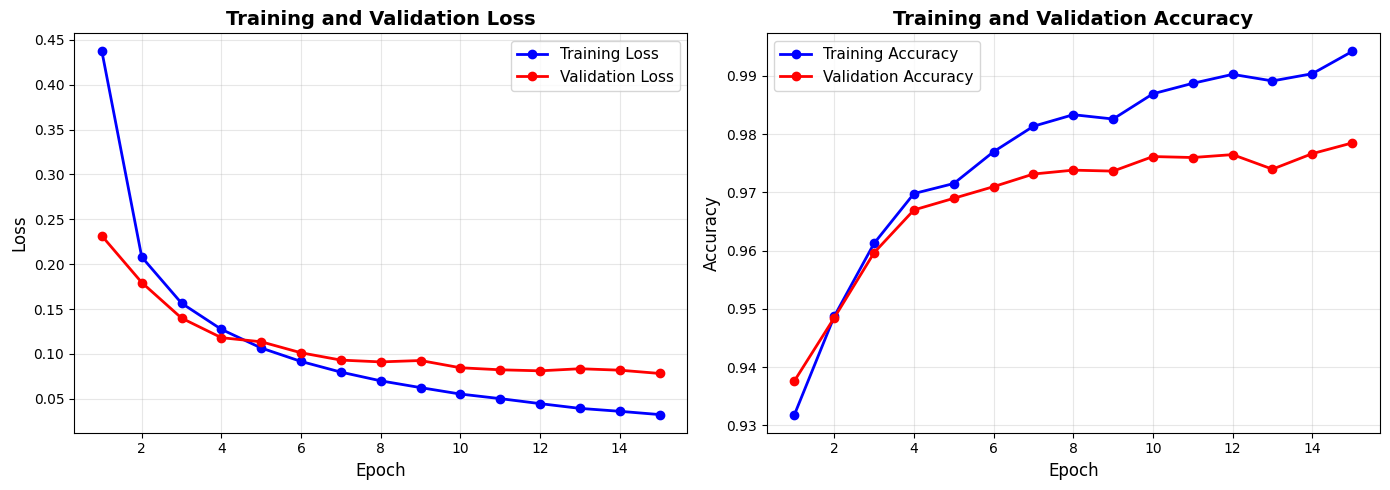

✓ Training visualization completed!

4.5: Final Model Evaluation on Test Set
--------------------------------------------------------------------------------
Making predictions on test set...
✓ Predictions completed!
  - Test Loss: 0.0791



In [ ]:
# 4.1: Define Network Architecture
print("\n4.1: Network Architecture Configuration")
print("-"*80)

# Network structure: [input, hidden1, hidden2, output]
layer_dims = [784, 128, 64, 10]

print(f"Network Architecture:")
print(f"  - Input Layer: {layer_dims[0]} neurons (28×28 pixels)")
print(f"  - Hidden Layer 1: {layer_dims[1]} neurons (ReLU activation)")
print(f"  - Hidden Layer 2: {layer_dims[2]} neurons (ReLU activation)")
print(f"  - Output Layer: {layer_dims[3]} neurons (Softmax activation)")

total_params = sum([layer_dims[i] * layer_dims[i+1] + layer_dims[i+1]
                    for i in range(len(layer_dims)-1)])
print(f"  - Total trainable parameters: {total_params:,}")


# 4.2: Initialize Parameters
print("\n4.2: Initializing Network Parameters")
print("-"*80)

parameters = initialize_parameters(layer_dims)

print(f"✓ Parameters initialized!")
for key in parameters:
    print(f"  - {key}: shape {parameters[key].shape}")


# 4.3: Training Loop with Mini-Batch Gradient Descent
print("\n4.3: Training Loop")
print("-"*80)
print("Starting training with mini-batch gradient descent...")

# Training hyperparameters
epochs = 15
batch_size = 128
learning_rate = 0.1

# Training history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

n_samples = X_train.shape[0]
n_batches = n_samples // batch_size

print(f"\nHyperparameters:")
print(f"  - Epochs: {epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Learning rate: {learning_rate}")
print(f"  - Batches per epoch: {n_batches}")

print("\n" + "="*80)
print("Training Progress:")
print("="*80)

for epoch in range(epochs):
    # Shuffle training data
    indices = np.random.permutation(n_samples)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train_encoded[indices]

    epoch_loss = 0

    # Mini-batch training
    for batch_idx in range(n_batches):
        # Get mini-batch
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        X_batch = X_train_shuffled[start_idx:end_idx]
        y_batch = y_train_shuffled[start_idx:end_idx]

        # Forward propagation
        AL, caches = forward_propagation(X_batch, parameters)

        # Compute loss
        batch_loss = compute_cross_entropy_loss(AL, y_batch)
        epoch_loss += batch_loss

        # Backward propagation
        grads = backward_propagation(AL, y_batch, caches)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

    # Average loss for epoch
    avg_train_loss = epoch_loss / n_batches

    # Evaluate on training set
    train_predictions, _ = forward_propagation(X_train, parameters)
    train_pred_labels = np.argmax(train_predictions, axis=1)
    train_acc = np.mean(train_pred_labels == y_train)

    # Evaluate on validation set
    val_predictions, _ = forward_propagation(X_val, parameters)
    val_loss = compute_cross_entropy_loss(val_predictions, y_val_encoded)
    val_pred_labels = np.argmax(val_predictions, axis=1)
    val_acc = np.mean(val_pred_labels == y_val)

    # Store metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print progress
    print(f"Epoch {epoch+1:2d}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("="*80)
print("✓ Training completed successfully!")


# 4.4: Plot Training History
print("\n4.4: Visualizing Training History")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(range(1, epochs+1), train_losses, 'b-o', label='Training Loss', linewidth=2)
axes[0].plot(range(1, epochs+1), val_losses, 'r-o', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(range(1, epochs+1), train_accuracies, 'b-o', label='Training Accuracy', linewidth=2)
axes[1].plot(range(1, epochs+1), val_accuracies, 'r-o', label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training visualization completed!")


# 4.5: Test Set Evaluation
print("\n4.5: Final Model Evaluation on Test Set")
print("-"*80)
print("Making predictions on test set...")

test_predictions, _ = forward_propagation(X_test, parameters)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_loss = compute_cross_entropy_loss(test_predictions, y_test_encoded)

print(f"✓ Predictions completed!")
print(f"  - Test Loss: {test_loss:.4f}")

print()

# STEP 5: EVALUATION METRICS


5.1: Confusion Matrix
--------------------------------------------------------------------------------
Confusion Matrix (Rows: True Labels, Columns: Predicted Labels):

         0    1    2    3    4    5    6    7    8    9
     --------------------------------------------------
  0 |  978    1    1    2    2    0    0    0    1    1
  1 |    0 1117    2    2    1    0    0    1    2    0
  2 |    4    6  967    6    5    1    0    4    3    3
  3 |    2    1    2  995    0    8    0    6    5    1
  4 |    0    0    3    0  955    1    1    1    0   14
  5 |    2    1    0   11    2  876    4    0    2    4
  6 |    6    0    1    0    4    2  969    0    0    0
  7 |    3    7    6    1    5    0    0 1009    2    9
  8 |    4    5    1   16    0    6    3    2  933    5
  9 |    6    8    0    8   13    4    0    7    1  947

5.2: Accuracy
--------------------------------------------------------------------------------
Accuracy: 0.9746 (97.46%)
  - Correctly classified: 9746 / 100

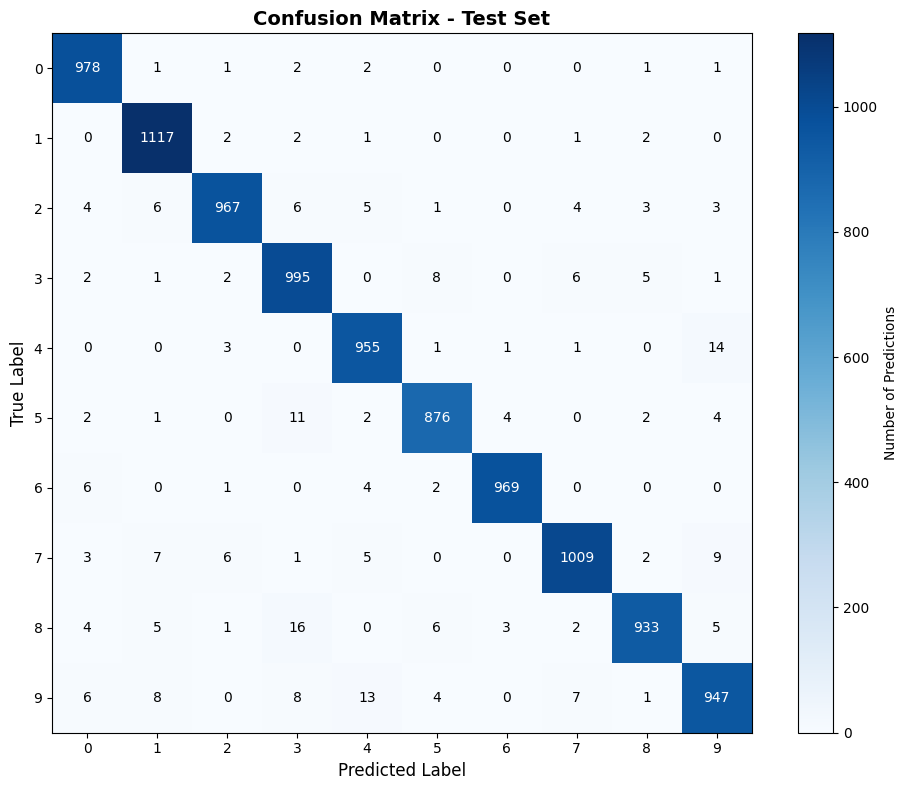

✓ Confusion matrix visualization completed!

5.7: Sample Predictions Visualization
--------------------------------------------------------------------------------


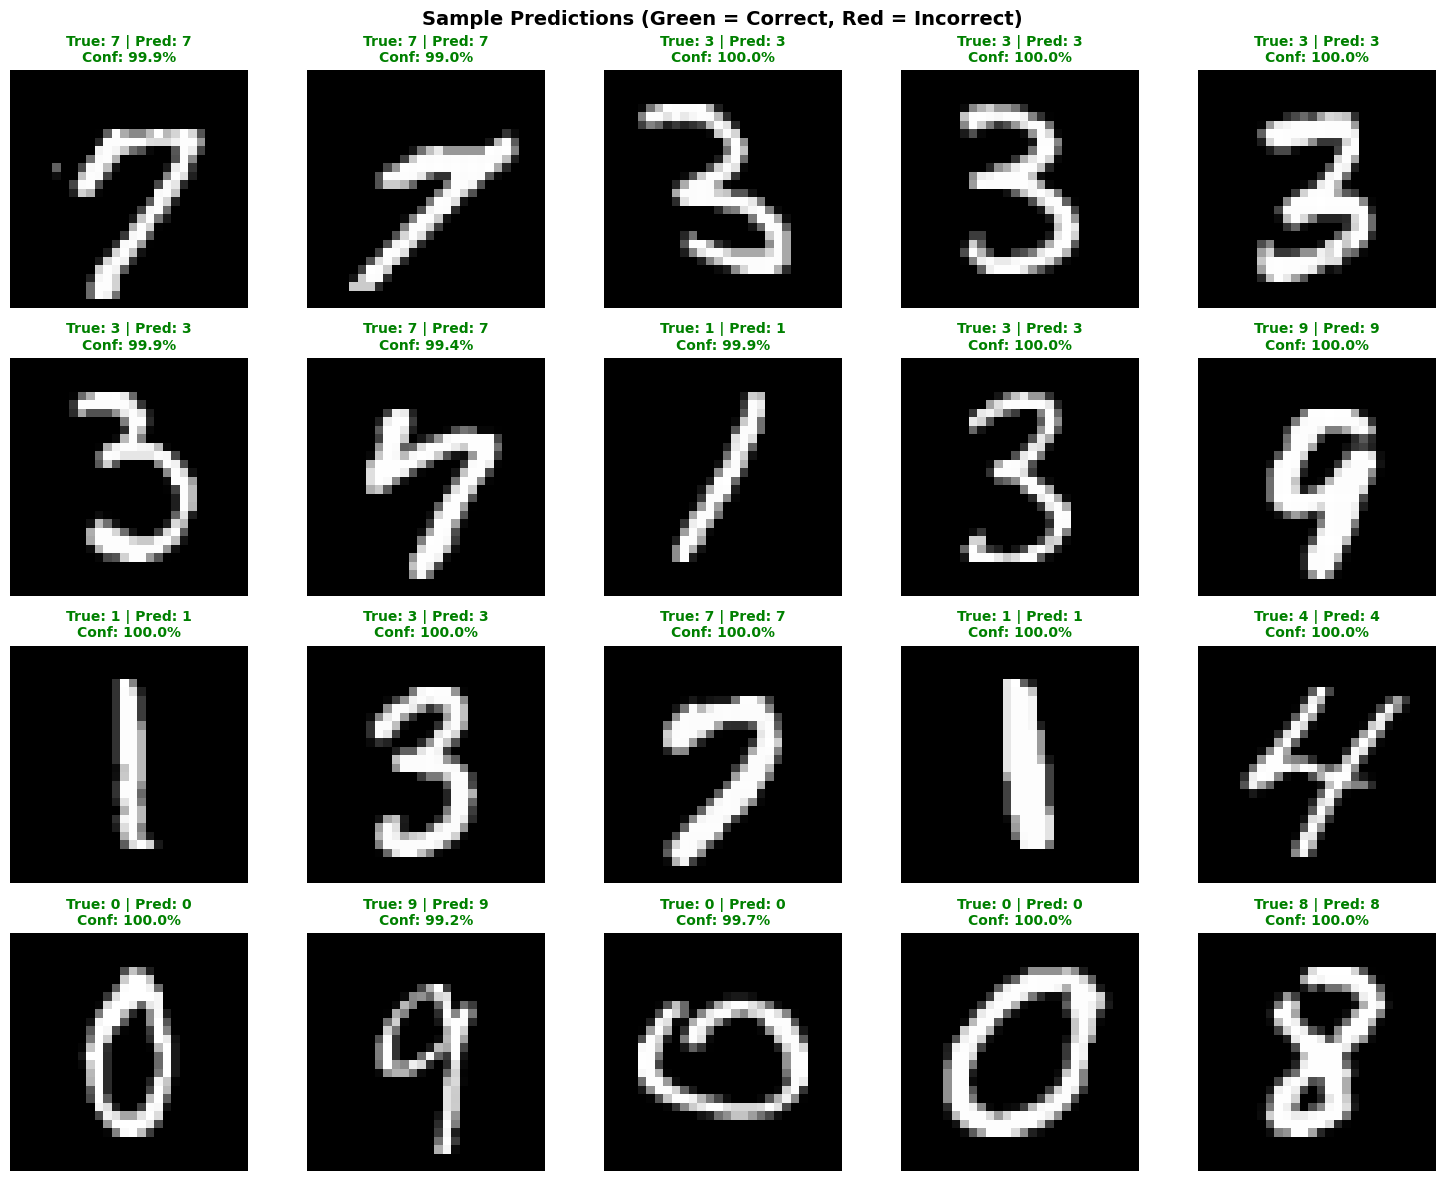

✓ Sample predictions visualization completed!


In [ ]:
# 5.1: Confusion Matrix
print("\n5.1: Confusion Matrix")
print("-"*80)

conf_matrix = confusion_matrix(y_test, test_pred_labels)

print("Confusion Matrix (Rows: True Labels, Columns: Predicted Labels):")
print()
print("     ", end="")
for i in range(10):
    print(f"{i:5d}", end="")
print()
print("     " + "-"*50)
for i in range(10):
    print(f"{i:3d} |", end="")
    for j in range(10):
        print(f"{conf_matrix[i,j]:5d}", end="")
    print()


# 5.2: Accuracy
print("\n5.2: Accuracy")
print("-"*80)

accuracy = accuracy_score(y_test, test_pred_labels)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - Correctly classified: {int(accuracy * len(y_test))} / {len(y_test)}")


# 5.3: Precision
print("\n5.3: Precision")
print("-"*80)

precision = precision_score(y_test, test_pred_labels, average='weighted')
print(f"Precision (weighted): {precision:.4f}")
print("  - Measures: What proportion of positive predictions are correct?")


# 5.4: F1 Score
print("\n5.4: F1 Score")
print("-"*80)

f1 = f1_score(y_test, test_pred_labels, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")
print("  - Harmonic mean of Precision and Recall")


# 5.5: Per-Class Metrics
print("\n5.5: Per-Class Performance")
print("-"*80)

precision_per_class = precision_score(y_test, test_pred_labels, average=None)
f1_per_class = f1_score(y_test, test_pred_labels, average=None)

print(f"{'Digit':<8} {'Precision':<12} {'F1 Score':<12} {'Samples':<10}")
print("-"*50)
for digit in range(10):
    n_samples = np.sum(y_test == digit)
    print(f"{digit:<8} {precision_per_class[digit]:<12.4f} {f1_per_class[digit]:<12.4f} {n_samples:<10}")


# 5.6: Visualize Confusion Matrix
print("\n5.6: Confusion Matrix Visualization")
print("-"*80)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar(label='Number of Predictions')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')

# Add text annotations
thresh = conf_matrix.max() / 2
for i in range(10):
    for j in range(10):
        plt.text(j, i, conf_matrix[i, j],
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > thresh else "black",
                fontsize=10)

plt.xticks(range(10))
plt.yticks(range(10))
plt.tight_layout()
plt.show()

print("✓ Confusion matrix visualization completed!")


# 5.7: Visualize Sample Predictions
print("\n5.7: Sample Predictions Visualization")
print("-"*80)

# Select random test samples
np.random.seed(100)
sample_indices = np.random.choice(len(X_test), 20, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    # Get image and predictions
    image = X_test[idx].reshape(28, 28)
    true_label = y_test[idx]
    pred_label = test_pred_labels[idx]
    confidence = test_predictions[idx, pred_label] * 100

    # Plot
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

    # Color code: green if correct, red if wrong
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(f'True: {true_label} | Pred: {pred_label}\nConf: {confidence:.1f}%',
                     color=color, fontsize=10, fontweight='bold')

plt.suptitle('Sample Predictions (Green = Correct, Red = Incorrect)',
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Sample predictions visualization completed!")